# Filtered Visualization of Nonstructural Fragility Models and Curves 
This app lets researchers filter and visualize fragility models and their curves for nonstructural components. It targets scholarly use, providing a taxonomy-aligned view of the NED database where components are organized by NISTIR group element, component identity, detail, material, and size class. Within this scope, the tool exposes the population of available fragility models and their associated lognormal functions that map an engineering demand parameter to the probability of damage exceedance.

In [11]:
import numpy as np
import scipy as sp
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
import sqlite3
from IPython.display import display, clear_output
import base64
import io
from IPython.display import HTML
from IPython.display import FileLink
import re



In [12]:
# Connect to the SQLite database
conn = sqlite3.connect('db.sqlite3')

# Read the 'ned_experiment' table
df = pd.read_sql_query("SELECT * FROM ned_app_experiment", conn)
df_component = pd.read_sql_query("SELECT * FROM ned_app_component", conn)
df_fragilitymodel = pd.read_sql_query("SELECT * FROM ned_app_fragilitymodel", conn)
df_fragilitycurve = pd.read_sql_query("SELECT * FROM ned_app_fragilitycurve", conn)
df_nistirgroupelement = pd.read_sql_query("SELECT * FROM ned_app_nistirgroupelement", conn)

## Characterize Data
A categorical histogram of the number of datapoints available for each component type in the database is plotted.

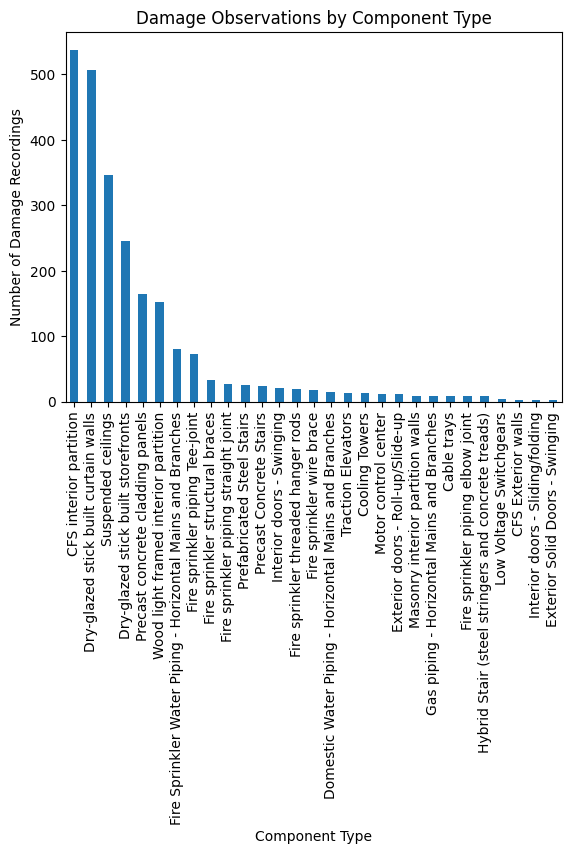

In [13]:
current_selection = {
    'comptype': None,
    'edp': None,
    'detail': None,
    'material': None,
    'size': None
}

# Merge df (experiment) with df_component to get component name
df_merged = df.merge(df_component[['id', 'name']], left_on='component_id', right_on='id', how='left')

# Now plot using 'name' instead of old 'comp_type'
ax = df_merged['name'].value_counts(sort=True).plot.bar(rot=90, title='Damage Observations by Component Type')
ax.set_ylabel("Number of Damage Recordings")
ax.set_xlabel("Component Type")

# Update comp_types using the new 'name' column
comp_types = df_merged['name'].unique()
edp_types = df_merged['edp_metric'].unique()

### Table of Filtered fragility data
This table displays all individual fragility data from the database that match the selected filters. Use the dropdowns to filter by NistGroupelment, component type, detail, material, and size. The table updates automatically when any filter changes. You can download filtered data as a CSV file by clicking "**Download CSV**."

In [21]:
# ---- Use fragility MODEL + CURVE instead of experiment ----

# Merge fragility models with component names and keep the textual component code
# ---- Use fragility MODEL + CURVE instead of experiment ----
df_fm = df_fragilitymodel.copy().rename(columns={'id': 'fragility_model_id'})
df_fm_merged = df_fm.merge(
    df_component[['id', 'name', 'nistir_subelement_id']].rename(columns={'id': 'component_code'}),
    left_on='component_id',
    right_on='component_code',
    how='left'
)


# Dropdown widgets (component choices from fragility models)
comp_dropdown = widgets.Dropdown(
    options=sorted(df_fm_merged['name'].dropna().unique()),
    description="Component"
)

_ng = df_nistirgroupelement[['id','name']].dropna().copy()
_ng['id'] = _ng['id'].astype(str)

# options = [(label, value)] so the user sees "B10 Super Structure" but value is "B10"
_ng_opts = [("All", "All")] + [(f"{row['id']} {row['name']}", row['id']) for _, row in _ng.sort_values('id').iterrows()]

nist_dropdown = widgets.Dropdown(
    options=_ng_opts,
    description="NistGroupelment",
    value="All",
)

detail_dropdown = widgets.Dropdown(description="Detail")
material_dropdown = widgets.Dropdown(description="Material")
size_dropdown = widgets.Dropdown(description="Size")

# show full labels and align every row from the left
LABEL_W = '180px'            # wide enough for "NistGroupelment"
FIELD_W = '520px'            # width of the dropdown box

# make sure NistGroupelment actually shows its full label
nist_dropdown.description = 'NistGroupelment'
for w in (nist_dropdown, comp_dropdown, detail_dropdown, material_dropdown, size_dropdown):
    w.style = {'description_width': LABEL_W}     # same label width = left aligned, no ellipsis
    w.layout = widgets.Layout(width=FIELD_W)     # same field width for all

page_slider = widgets.IntSlider(value=1, min=1, description='Page', step=1)




# Output
table_output = widgets.Output(
    layout=widgets.Layout(
        overflow='auto',
        max_height='400px',
        border='1px solid #ddd'
    )
)

# Internal state
filtered_df_global = pd.DataFrame()

# Update filter options based on fragility MODEL records for the chosen component
def update_filter_options(*args):
    subdf = df_fm_merged[df_fm_merged['name'] == comp_dropdown.value]
    detail_dropdown.options = ["All"] + sorted(subdf['comp_detail'].dropna().unique())
    material_dropdown.options = ["All"] + sorted(subdf['material'].dropna().unique())
    size_dropdown.options = ["All"] + sorted(subdf['size_class'].dropna().unique())
    detail_dropdown.value = "All"
    material_dropdown.value = "All"
    size_dropdown.value = "All"

comp_dropdown.observe(lambda change: update_filter_options(), names='value')
update_filter_options()

# NEW: Rebuild Component choices based on NistGroupelment prefix
def refresh_comp_options(change=None):
    pref = nist_dropdown.value  # e.g., "A20", "B10", or "All"

    # Use nistir_subelement_id when available (e.g., B2011), else fall back
    if 'nistir_subelement_id' in df_fm_merged.columns:
        codes = df_fm_merged['nistir_subelement_id'].astype(str)
    elif 'component_code' in df_fm_merged.columns:
        codes = df_fm_merged['component_code'].astype(str)
    else:
        codes = df_fm_merged['component_id'].astype(str)

    codes = codes.str.strip().str.upper()

    if pref and pref != "All":
        # Exact prefix like "A20"
        mask = codes.str.startswith(pref.upper())
        avail = df_fm_merged.loc[mask, 'name'].dropna().unique()

        # Fallback: if none, use the first letter group (e.g., "B")
        if avail.size == 0:
            mask = codes.str.startswith(pref[0].upper())
            avail = df_fm_merged.loc[mask, 'name'].dropna().unique()

        avail_names = sorted(avail.tolist())
    else:
        avail_names = sorted(df_fm_merged['name'].dropna().unique())

    comp_dropdown.options = avail_names
    comp_dropdown.value = avail_names[0] if avail_names else None

    update_filter_options()
    try:
        refresh_model_list()
    except NameError:
        pass
    show_paginated_table()





# Filter data: get fragility_model_ids then fetch matching fragility CURVE rows
def filter_data():
    fm = df_fm_merged[df_fm_merged['name'] == comp_dropdown.value]
    if detail_dropdown.value != "All":
        fm = fm[fm['comp_detail'] == detail_dropdown.value]
    if material_dropdown.value != "All":
        fm = fm[fm['material'] == material_dropdown.value]
    if size_dropdown.value != "All":
        fm = fm[fm['size_class'] == size_dropdown.value]

    fm_ids = fm['fragility_model_id'].dropna().unique().tolist()
    if len(fm_ids) == 0:
        return pd.DataFrame()

    # Pull matching rows from fragilitycurve
    curves = df_fragilitycurve[df_fragilitycurve['fragility_model_id'].isin(fm_ids)].copy()

    # Add context columns from the filtered models (component, detail, material, size)
    context_cols = ['fragility_model_id', 'name', 'comp_detail', 'material', 'size_class']
    curves = curves.merge(fm[context_cols].drop_duplicates(), on='fragility_model_id', how='left')

    # Hide columns from display and download
    hide_cols = ['id', 'reviewer', 'name', 'comp_detail', 'material', 'size_class']

    # Hide columns from display and download
    hide_cols = ['id', 'reviewer', 'name', 'comp_detail', 'material', 'size_class']
    curves = curves.drop(columns=hide_cols, errors='ignore')

    # Put fragility_model_id first
    if 'fragility_model_id' in curves.columns:
        cols = ['fragility_model_id'] + [c for c in curves.columns if c != 'fragility_model_id']
        curves = curves[cols]

    return curves.reset_index(drop=True)

# Paginated table display
def show_paginated_table(change=None):
    global filtered_df_global
    filtered_df_global = filter_data()

    total_rows = filtered_df_global.shape[0]
    rows_per_page = 20
    total_pages = max(1, (total_rows + rows_per_page - 1) // rows_per_page)
    page_slider.max = total_pages

    if total_rows == 0:
        with table_output:
            clear_output()
            print("No matching records to display.")
        return

    start = (page_slider.value - 1) * rows_per_page
    end = start + rows_per_page
    page_df = filtered_df_global.iloc[start:end]

    # Convert to HTML table without index
    html_table = page_df.to_html(index=False)

    # Sticky header styles
    html_table = html_table.replace(
        "<thead>",
        '<thead style="position: sticky; top: 0; background-color: white; z-index: 1;">'
    ).replace(
        "<th>",
        '<th style="position: sticky; top: 0; background-color: white; border-bottom: 1px solid #ccc; padding: 8px;">'
    )

    # Wrap in scrollable div
    scrollable_html = f'''
    <div style="
        max-height: 350px;
        overflow: auto;
        border: 1px solid #ccc;
        padding: 4px;
    ">
        <div style="min-width: 1000px;">
            {html_table}
        </div>
    </div>
    '''

    with table_output:
        clear_output()
        display(HTML(scrollable_html))

# Download button
download_button = widgets.Button(description="Download CSV")

def download_csv(b):
    if not filtered_df_global.empty:
        csv_bytes = filtered_df_global.to_csv(index=False).encode()
        b64 = base64.b64encode(csv_bytes).decode()
        fname = "filtered_fragilitycurves.csv"
        link = f'<a download="{fname}" href="data:text/csv;base64,{b64}" target="_blank"><b>👉 Click here to download CSV</b></a>'
        with table_output:
            display(HTML(link))

download_button.on_click(download_csv)

# Trigger table update on filter changes
comp_dropdown.observe(lambda change: show_paginated_table(), names='value')
detail_dropdown.observe(lambda change: show_paginated_table(), names='value')
material_dropdown.observe(lambda change: show_paginated_table(), names='value')
size_dropdown.observe(lambda change: show_paginated_table(), names='value')
page_slider.observe(show_paginated_table, names='value')
# NEW: observe changes in NistGroupelment
nist_dropdown.observe(refresh_comp_options, names='value')

# Initial sync of component options with current NistGroupelment selection
refresh_comp_options()


# Initial display
show_paginated_table()

# UI layout
ui = widgets.VBox([
    nist_dropdown,         # NEW: high-level filter first
    comp_dropdown,
    detail_dropdown,
    material_dropdown,
    size_dropdown,
    page_slider,
    table_output,
    download_button
])
display(ui)


### Fragility Curves by Model
Use this section to preview fragility curves for a specific model. It lists the fragility model IDs that match your current filters (NistGroupelment, Component, Detail, Material, Size); pick an ID from the dropdown to plot its curves. The list and plot update automatically when any filter changes. If nothing matches, a clear message is shown.

In [7]:
# === Append-only: Fragility Model selector + plot (run after display(ui)) ===

# Small status + new widgets
fm_status = widgets.HTML(value="")
fm_dropdown = widgets.Dropdown(description="", options=[], disabled=True)
try:
    fm_dropdown.label_visibility = "collapsed"  # ipywidgets 8+
except Exception:
    fm_dropdown.style = {"description_width": "0px"}  # fallback for older versions

plot_output = widgets.Output()

# Map dropdown strings -> original IDs (keeps types safe)
fm_id_map = {}

def _filtered_models_df():
    # Start from the models merge you already built
    fm = df_fm_merged.copy()

    # Component
    comp_val = comp_dropdown.value
    if comp_val is not None:
        fm = fm[fm['name'].astype(str).str.strip() == str(comp_val).strip()]

    # Detail, Material, Size (respect "All")
    if 'comp_detail' in fm.columns and detail_dropdown.value and detail_dropdown.value != "All":
        fm = fm[fm['comp_detail'] == detail_dropdown.value]
    if 'material' in fm.columns and material_dropdown.value and material_dropdown.value != "All":
        fm = fm[fm['material'] == material_dropdown.value]
    if 'size_class' in fm.columns and size_dropdown.value and size_dropdown.value != "All":
        fm = fm[fm['size_class'] == size_dropdown.value]

    return fm

def refresh_model_list(change=None):
    global fm_id_map
    fm = _filtered_models_df()

    if 'fragility_model_id' not in fm.columns:
        fm_dropdown.options = []
        fm_dropdown.value = None
        fm_dropdown.disabled = True
        fm_status.value = "<b>Matching fragility models:</b>"
        with plot_output:
            clear_output()
            print("No fragility model matches the current filters.")
        return

    ids_raw = fm['fragility_model_id'].dropna().unique().tolist()
    # Use strings in the dropdown, but remember original values
    fm_id_map = {str(x): x for x in ids_raw}
    opts = list(fm_id_map.keys())

    fm_dropdown.options = opts
    fm_dropdown.disabled = (len(opts) == 0)
    fm_status.value = "<b>Matching fragility models:</b>"

    if opts:
        # Keep selection if still valid, else pick first
        fm_dropdown.value = fm_dropdown.value if fm_dropdown.value in opts else opts[0]
    else:
        fm_dropdown.value = None
        with plot_output:
            clear_output()
            print("No fragility model matches the current filters.")

def _resolve_mu_beta(df_in):
    df = df_in.copy()

    # mu from 'mu' or log of 'median'/'theta'
    if 'mu' in df.columns:
        df['_mu'] = pd.to_numeric(df['mu'], errors='coerce')
    elif 'median' in df.columns:
        df['_mu'] = np.log(pd.to_numeric(df['median'], errors='coerce'))
    elif 'theta' in df.columns:
        df['_mu'] = np.log(pd.to_numeric(df['theta'], errors='coerce'))
    else:
        df['_mu'] = np.nan

    # beta from 'beta' or 'log_std'
    if 'beta' in df.columns:
        df['_beta'] = pd.to_numeric(df['beta'], errors='coerce')
    elif 'log_std' in df.columns:
        df['_beta'] = pd.to_numeric(df['log_std'], errors='coerce')
    else:
        df['_beta'] = np.nan

    return df

def _to_roman(n: int) -> str:
    vals = [(1000,'M'),(900,'CM'),(500,'D'),(400,'CD'),
            (100,'C'),(90,'XC'),(50,'L'),(40,'XL'),
            (10,'X'),(9,'IX'),(5,'V'),(4,'IV'),(1,'I')]
    s = ""
    for v, ch in vals:
        while n >= v:
            s += ch
            n -= v
    return s

def plot_selected_model(change=None):
    with plot_output:
        clear_output()
        sel = fm_dropdown.value
        if not sel:
            print("No fragility model selected.")
            return

        fm_id = fm_id_map.get(sel, sel)  # convert back to original ID
        curves = df_fragilitycurve[df_fragilitycurve['fragility_model_id'] == fm_id].copy()
        if curves.empty:
            print("No fragility curves found for the selected model.")
            return

        curves = _resolve_mu_beta(curves)
        valid = curves[np.isfinite(curves['_mu']) & np.isfinite(curves['_beta'])]
        if valid.empty:
            print("Missing mu or beta. Expected columns: mu or median/theta, and beta or log_std.")
            return

        # Build x range from medians and betas
        medians = np.exp(valid['_mu'].values)
        betas = valid['_beta'].values
        x_max = np.nanmax(medians * np.exp(3 * betas))
        if not np.isfinite(x_max) or x_max <= 0:
            x_max = max(1.0, float(np.nanmax(medians)) * 3)
        x = np.linspace(0, x_max, 400)

        fig, ax = plt.subplots()
        for i, (_, r) in enumerate(valid.iterrows(), start=1):
            mu_i = float(r['_mu'])
            beta_i = float(r['_beta'])
            cdf = stats.lognorm.cdf(x, s=beta_i, scale=np.exp(mu_i))
            ax.plot(x, cdf, label=f"Curve {_to_roman(i)}")

        # X axis label from any plausible column
        xlabel = None
        for cand in ['edp_metric', 'edp', 'intensity_measure', 'im', 'IM']:
            if cand in curves.columns and pd.notna(curves[cand].iloc[0]):
                xlabel = str(curves[cand].iloc[0])
                break

        ax.set_xlabel(xlabel if xlabel else "EDP / IM")
        ax.set_ylabel("rank")
        ax.set_title(f"Fragility curves for Model {sel}")
        ax.set_xlim(left=0)
        ax.set_ylim(0, 1)
        ax.legend(loc='best')
        plt.show()

# Sync model list with existing filters
comp_dropdown.observe(refresh_model_list, names='value')
detail_dropdown.observe(refresh_model_list, names='value')
material_dropdown.observe(refresh_model_list, names='value')
size_dropdown.observe(refresh_model_list, names='value')

# Replot on model change
fm_dropdown.observe(plot_selected_model, names='value')

# Init and display only the new widgets
refresh_model_list()
display(widgets.VBox([widgets.HBox([fm_status, fm_dropdown]), plot_output]))
